dataset: https://www.kaggle.com/andyczhao/covidx-cxr2?select=train.txt

In [1]:
#importing the libraries
import pandas as pd
import os
import numpy as np
import time
import copy
import warnings
from tqdm import tqdm

#for reading and displaying images
import matplotlib.pyplot as plt
from PIL import Image
import cv2

#Pytorch libraries and modules
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary

from torch.nn import Linear, CrossEntropyLoss
from torch.optim import Adam, lr_scheduler
from torch.utils.data import DataLoader,Dataset
from sklearn.model_selection import train_test_split

#torchvision for pre-trained models and augmentation
import torchvision
import torchvision.transforms as transforms
from torchvision import models

#for evaluating model
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import KFold

In [2]:
#tao duong dan den data
train_path = './train/'
test_path = os.getcwd() + '/test/'

In [3]:
#doc file metadata
train_metadata = 'train.txt'
test_metadata = 'test.txt'
train_txt= pd.read_csv(train_metadata, sep=" ", header=None)
test_txt = pd.read_csv(test_metadata, sep=" ", header=None)

In [4]:
#gan ten cot
train_txt.columns= ["patient id","file_name","class","source"]
train_txt.head()

,patient id,file_name,class,source
0,5,ARDSSevere.png,negative,cohen
1,25,acute-respiratory-distress-syndrome-ards-1.jpg,negative,cohen
2,26,acute-respiratory-distress-syndrome-ards.jpg,negative,cohen
3,27,ards-secondary-to-tiger-snake-bite.png,negative,cohen
4,28,pneumocystis-pneumonia-2-PA.png,negative,cohen


In [5]:
#https://www.dataquest.io/blog/tutorial-add-column-pandas-dataframe-based-on-if-else-condition/
train_txt['label'] = np.where(train_txt['class']== 'negative', 0, 1) #tao cot label theo dk cua class
train_txt

,patient id,file_name,class,source,label
0,5,ARDSSevere.png,negative,cohen,0
1,25,acute-respiratory-distress-syndrome-ards-1.jpg,negative,cohen,0
2,26,acute-respiratory-distress-syndrome-ards.jpg,negative,cohen,0
3,27,ards-secondary-to-tiger-snake-bite.png,negative,cohen,0
4,28,pneumocystis-pneumonia-2-PA.png,negative,cohen,0
...,...,...,...,...,...
15946,c1628c47-5ba3-42dd-8df3-7ad3abd57ad0,c1628c47-5ba3-42dd-8df3-7ad3abd57ad0.png,negative,rsna,0
15947,c1cddf32-b957-4753-acaa-472ab1447e86,c1cddf32-b957-4753-acaa-472ab1447e86.png,negative,rsna,0
15948,c1e73a4e-7afe-4ec5-8af6-ce8315d7a2f2,c1e73a4e-7afe-4ec5-8af6-ce8315d7a2f2.png,negative,rsna,0
15949,c1ec14ff-f6d7-4b38-b0cb-fe07041cbdc8,c1ec14ff-f6d7-4b38-b0cb-fe07041cbdc8.png,negative,rsna,0


In [6]:
#chi lay cot filename va label (1,4)
train_txt1 = train_txt.iloc[:,[1,4]]
train_txt1

,file_name,label
0,ARDSSevere.png,0
1,acute-respiratory-distress-syndrome-ards-1.jpg,0
2,acute-respiratory-distress-syndrome-ards.jpg,0
3,ards-secondary-to-tiger-snake-bite.png,0
4,pneumocystis-pneumonia-2-PA.png,0
...,...,...
15946,c1628c47-5ba3-42dd-8df3-7ad3abd57ad0.png,0
15947,c1cddf32-b957-4753-acaa-472ab1447e86.png,0
15948,c1e73a4e-7afe-4ec5-8af6-ce8315d7a2f2.png,0
15949,c1ec14ff-f6d7-4b38-b0cb-fe07041cbdc8.png,0


In [7]:
#gan ten cot tren file test
test_txt.columns= ["patient id","file_name","class","source"]
test_txt.head()

,patient id,file_name,class,source
0,419639-003251,MIDRC-RICORD-1C-419639-003251-46647-0.png,positive,ricord
1,419639-001464,MIDRC-RICORD-1C-419639-001464-39871-0.png,positive,ricord
2,419639-000918,MIDRC-RICORD-1C-419639-000918-78965-0.png,positive,ricord
3,419639-003318,MIDRC-RICORD-1C-419639-003318-64285-0.png,positive,ricord
4,419639-001015,MIDRC-RICORD-1C-419639-001015-81591-0.png,positive,ricord


In [8]:
test_txt['label'] = np.where(test_txt['class']== 'negative', 0, 1) #tao cot label theo dk cua class
test_txt

,patient id,file_name,class,source,label
0,419639-003251,MIDRC-RICORD-1C-419639-003251-46647-0.png,positive,ricord,1
1,419639-001464,MIDRC-RICORD-1C-419639-001464-39871-0.png,positive,ricord,1
2,419639-000918,MIDRC-RICORD-1C-419639-000918-78965-0.png,positive,ricord,1
3,419639-003318,MIDRC-RICORD-1C-419639-003318-64285-0.png,positive,ricord,1
4,419639-001015,MIDRC-RICORD-1C-419639-001015-81591-0.png,positive,ricord,1
...,...,...,...,...,...
395,a77b32f6-1999-4cc6-8a0d-1ef7e53850f0,a77b32f6-1999-4cc6-8a0d-1ef7e53850f0.png,negative,rsna,0
396,41bf2042-53a2-44a8-9a29-55e643af5ac0,41bf2042-53a2-44a8-9a29-55e643af5ac0.png,negative,rsna,0
397,ec09ddb3-9b0b-4749-9e0d-f94a4a7e5fed,ec09ddb3-9b0b-4749-9e0d-f94a4a7e5fed.png,negative,rsna,0
398,abff4044-3c0a-458f-b0c7-04254be7fc0c,abff4044-3c0a-458f-b0c7-04254be7fc0c.png,negative,rsna,0


In [9]:
#chi lay cot filename va label (1,4)
test_txt1 = test_txt.iloc[:,[1,4]]
test_txt1

,file_name,label
0,MIDRC-RICORD-1C-419639-003251-46647-0.png,1
1,MIDRC-RICORD-1C-419639-001464-39871-0.png,1
2,MIDRC-RICORD-1C-419639-000918-78965-0.png,1
3,MIDRC-RICORD-1C-419639-003318-64285-0.png,1
4,MIDRC-RICORD-1C-419639-001015-81591-0.png,1
...,...,...
395,a77b32f6-1999-4cc6-8a0d-1ef7e53850f0.png,0
396,41bf2042-53a2-44a8-9a29-55e643af5ac0.png,0
397,ec09ddb3-9b0b-4749-9e0d-f94a4a7e5fed.png,0
398,abff4044-3c0a-458f-b0c7-04254be7fc0c.png,0


In [10]:
train_set,val_set=train_test_split(train_txt1,test_size=0.2, random_state = 42, shuffle=True)

In [11]:
train_txt1

,file_name,label
0,ARDSSevere.png,0
1,acute-respiratory-distress-syndrome-ards-1.jpg,0
2,acute-respiratory-distress-syndrome-ards.jpg,0
3,ards-secondary-to-tiger-snake-bite.png,0
4,pneumocystis-pneumonia-2-PA.png,0
...,...,...
15946,c1628c47-5ba3-42dd-8df3-7ad3abd57ad0.png,0
15947,c1cddf32-b957-4753-acaa-472ab1447e86.png,0
15948,c1e73a4e-7afe-4ec5-8af6-ce8315d7a2f2.png,0
15949,c1ec14ff-f6d7-4b38-b0cb-fe07041cbdc8.png,0


In [12]:
train_set

,file_name,label
7553,aec8c4ac-c66d-4523-a3df-278d0b7bead7.png,0
4215,5426d29c-8b15-401f-9453-bff645260899.png,0
11736,3fcc1a52-4329-4c61-9a79-f62c237387dc.png,0
578,10.1016-slash-j.cardfail.2020.04.007-b.png,1
10153,fddfb799-68be-418d-8caf-c99045137eb8.png,0
...,...,...
13418,a02c7ae4-7571-4ae8-ae35-5e4121ebd250.png,0
5390,7462adfa-a0fc-4489-8d58-89f1d012c26a.png,0
860,COVID(151).png,1
15795,1ffee791-10f6-4b8f-bfcd-35220e8e0003.png,0


In [13]:
val_set

,file_name,label
1328,COVID(623).png,1
9694,eea5fa9b-b0d2-4ae1-8ac1-db63d0f5bf01.png,0
4367,5871b176-cee8-4b9b-80e0-a6a4cf36d1b6.png,0
10504,301f54f3-b074-4fa9-9db2-d303fbbf54f0.png,0
6987,9ea70274-1e3d-4fe9-ad36-73334656b134.png,0
...,...,...
2331,MIDRC-RICORD-1C-419639-003220-02012-1.png,1
12673,79bb5ea3-ca6c-4d75-a379-a6ee6c6da659.png,0
4139,51702d7b-bbda-42f0-90a8-cb7cb1812a58.png,0
2549,MIDRC-RICORD-1C-SITE2-000268-51175-0.png,1


In [14]:
train_set.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12760 entries, 7553 to 7270
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  12760 non-null  object
 1   label      12760 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 299.1+ KB


In [15]:
BATCH_SIZE = 64
classes = ['Negative', 'Positive']
num_classes = 2
num_epochs = 30
criterion = CrossEntropyLoss()
CHECKPOINT_PATH = './FT_VGG19bn.pt'

std = np.array([0.229, 0.224, 0.225])
mean = np.array([0.485, 0.456, 0.406])

In [16]:
#https://stanford.edu/~shervine/blog/pytorch-how-to-generate-data-parallel
class ImageDataset(Dataset):
    def __init__(self,csv,img_folder,transform): # 'Initialization'
        self.csv=csv
        self.transform=transform
        self.img_folder=img_folder
    
        self.image_names=self.csv[:]['file_name']# [:] lấy hết số cột số hàng của bảng
        self.labels= np.array(self.csv[:]['label']) # note kiểu mảng int đúng không?
  
    def __len__(self):  # 'Denotes the total number of samples'
        return len(self.image_names)

    def __getitem__(self,index): # 'Generates one sample of data'
    
        image=Image.open(self.img_folder + self.image_names.iloc[index]).convert('RGB')
#         print('image',image)

        image=self.transform(image)
#         image.Resize((224,224))
        targets=self.labels[index]
        targets = torch.tensor(targets, dtype=torch.long) #đọc từng phần tử của mảng, chuyển từ array -> tensor; kiểu int64 tương ứng với long trong pytorch
        sample = {'image': image,'labels':targets} # day la 1 cap chi 2

        return sample # chua 1 cap

In [17]:
train_transform = transforms.Compose([
    transforms.Resize((360, 360)),
    transforms.RandomAffine(degrees = 0, shear = 0.2),
    transforms.CenterCrop(300),
    transforms.Resize((150,150)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

test_transform =transforms.Compose([
    transforms.Resize((360, 360)),
    transforms.CenterCrop(300),
    transforms.Resize((150,150)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

train_dataset=ImageDataset(train_set,train_path,train_transform)
val_dataset=ImageDataset(val_set,train_path,test_transform) ############
test_dataset=ImageDataset(test_txt,test_path,test_transform)

train_dataloader = DataLoader(
    train_dataset, 
    batch_size= BATCH_SIZE,
    shuffle=True
)

val_dataloader = DataLoader(
    val_dataset, 
    batch_size=BATCH_SIZE,
    shuffle=True
)

test_dataloader = DataLoader(
    test_dataset, 
    batch_size=BATCH_SIZE,
    shuffle=True
)

dataloader_dict = {'train': train_dataloader,
                  'val': val_dataloader,
                  'test':test_dataloader}

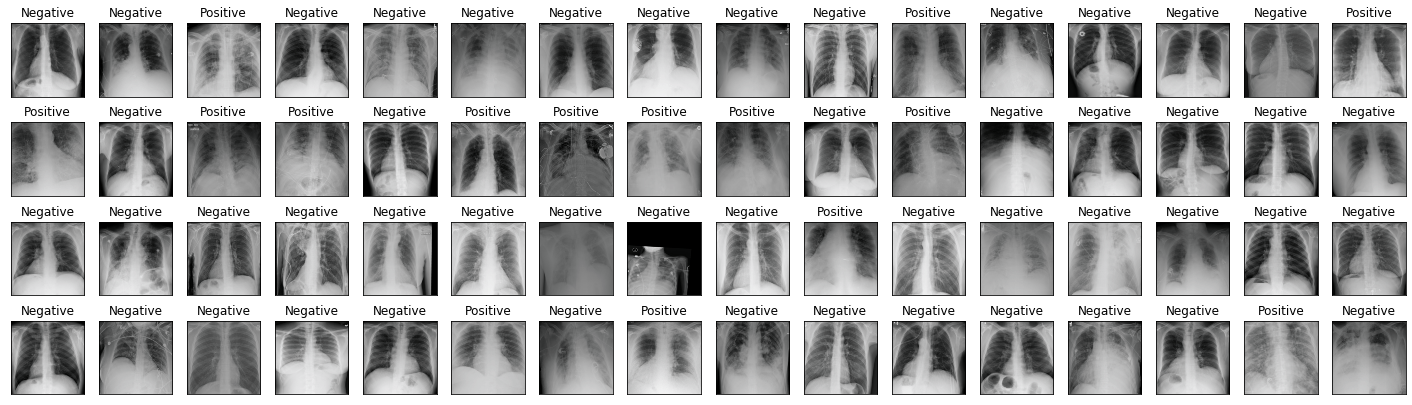

In [18]:
def imshow(inp, title=None):
    """imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    inp = std*inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    
    
# Get a batch of training data
sample = next(iter(train_dataloader))
fig = plt.figure(figsize=(25, 7))

# display batch_size = 40 images
for idx in np.arange(BATCH_SIZE):
    ax = fig.add_subplot(4, BATCH_SIZE/4, idx+1, xticks=[], yticks=[])
    imshow(sample['image'][idx]) # lay 1 cap co nghia la o day show anh
    ax.set_title(classes[sample['labels'][idx]]) # vì đã chuyển từ nes/pos -> 0,1 -> tensor 0,1

# from the scratch

In [19]:
# loading the pretrained model
model = models.vgg19_bn(pretrained = False)
# Flag for feature extracting. When False, we finetune the whole model,
#   when True we only update the reshaped layer params
feature_extract = False

In [20]:
print(model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

In [21]:
model.classifier[6] = Linear(4096, num_classes)

In [22]:
print(model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

# Define  Train the Model using Early Stopping

In [23]:
def training_loop(model, optimizer, start_epochs, end_epochs, loss_list, acc_list, scheduler):
    model.to(device)
    #List to store loss to visualize
#     since = time.time()
    lossli = loss_list
    accli = acc_list
    
    y_true = []
    y_pred = []
    
    valid_loss_min = np.Inf # track change in validation loss
#     valid_loss_min = 1.38
    count = 0
    patience = 15 # nếu val_loss tăng 15 lần thì ngừng
    for epoch in range(start_epochs, end_epochs):
        
        # keep track of training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        
        train_acc = 0.0
        valid_acc = 0.0
        
        ###################
        # train the model #
        ###################
        
        model.train()
        for sample in tqdm(train_dataloader):
            data = sample['image'].to(device)
            target = sample['labels'].to(device)
            optimizer.zero_grad()
            output = model(data)
            
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
        
            
            train_loss += loss.item()*data.size(0)
            
            _, pred = torch.max(output, 1)              
            
            train_acc += pred.eq(target).sum().item()
            
        scheduler.step() ###########
            
        ######################
        # validate the model #
        ######################
        
        model.eval()
        with torch.no_grad():
            for sample in tqdm(val_dataloader):
                data = sample['image'].to(device)
                target = sample['labels'].to(device)
                output = model(data)
                loss = criterion(output, target)
                valid_loss += loss.item()*data.size(0)
                
                # Calculate accuracy
                _, pred = torch.max(output, 1)
#                 y_true += target.tolist()
#                 y_pred += pred.tolist()  
                
                valid_acc +=  pred.eq(target).sum().item()
       
        # calculate average losses
        train_loss = train_loss/len(train_dataloader.dataset)
        valid_loss = valid_loss/len(val_dataloader.dataset)
        lossli.append({'epoch':epoch,'train_loss': train_loss,'valid_loss':valid_loss})
        
        train_acc = train_acc*100/len(train_dataloader.dataset)
        valid_acc = valid_acc*100/len(val_dataloader.dataset)
        accli.append({'epoch':epoch,'train_acc': train_acc,'valid_acc':valid_acc})
        
        
        #############################################################################
#         handle_1 = model.conv_layer[0].register_forward_hook(activation_hook)
#         model.conv_layer[1].register_forward_hook(activation_hook)
#         model.conv_layer[2].register_forward_hook(activation_hook)
#         model.conv_layer[3].register_forward_hook(activation_hook)
#         model.conv_layer[4].register_forward_hook(activation_hook)
#         model.conv_layer[5].register_forward_hook(activation_hook)
        ####################
        # Early stopping #
        ##################
        
        # print training/validation statistics
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, train_loss, valid_loss))
        # save model if validation loss has decreased
       
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_acc': accli,
            'loss_list': lossli,
            'loss': loss
            }, CHECKPOINT_PATH)
        
        if valid_loss <= valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}). Saving model ...'.format(
                valid_loss_min,
                valid_loss))
            
            count = 0
            print('count = ',count)
            torch.save(model, './VGG19bn_model.pt') #save model 
                                  
            valid_loss_min = valid_loss
        else:
            count += 1
            print('count = ',count)
            if count >= patience:
                print('Early stopping!')
#                 time_elapsed = time.time() - since
#                 print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    
                return lossli, accli    
#     time_elapsed = time.time() - since
#     print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
            
    return lossli, accli

In [24]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

In [25]:
#Create the optimizer
# params_to_update = model_ft.parameters()
# print('Params to learn:')
# if feature_extract:
#     params_to_update = []
#     for name, param in model_ft.named_parameters():
#         if param.requires_grad == True:
#             params_to_update.append(param)
#             print('\t',name)
# else:
#     for name, param in model_ft.named_parameters():
#         if param.requires_grad == True:
#             print('\t',name)

optimizer = Adam(model.parameters(), lr = 0.001, weight_decay=1e-5)
scheduler = lr_scheduler.MultiStepLR(optimizer, milestones = [20, 35], gamma=0.1, last_epoch=-1, verbose=False)

# Train the Model

In [26]:
loss_list, acc_list = [],[]

since = time.time()

loss, acc = training_loop(
    model = model,
    optimizer = optimizer,
    start_epochs = 1,
    end_epochs = num_epochs,
    loss_list = loss_list,
    acc_list = acc_list,
    scheduler = scheduler
)
time_elapsed = time.time() - since
print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

100%|██████████| 50/50 [01:00<00:00,  1.21s/it]


Epoch: 1 	Training Loss: 1.229978 	Validation Loss: 0.412271
Validation loss decreased (inf --> 0.412271). Saving model ...
count =  0


100%|██████████| 50/50 [01:00<00:00,  1.21s/it]


Epoch: 2 	Training Loss: 0.368852 	Validation Loss: 0.311939
Validation loss decreased (0.412271 --> 0.311939). Saving model ...
count =  0


100%|██████████| 50/50 [00:59<00:00,  1.19s/it]


Epoch: 3 	Training Loss: 0.336579 	Validation Loss: 0.268796
Validation loss decreased (0.311939 --> 0.268796). Saving model ...
count =  0


100%|██████████| 50/50 [01:00<00:00,  1.22s/it]


Epoch: 4 	Training Loss: 0.317664 	Validation Loss: 0.324743


  0%|          | 0/200 [00:00<?, ?it/s]

count =  1


100%|██████████| 50/50 [01:01<00:00,  1.22s/it]


Epoch: 5 	Training Loss: 0.283640 	Validation Loss: 0.233134
Validation loss decreased (0.268796 --> 0.233134). Saving model ...
count =  0


100%|██████████| 50/50 [01:00<00:00,  1.21s/it]


Epoch: 6 	Training Loss: 0.251600 	Validation Loss: 0.581769


  0%|          | 0/200 [00:00<?, ?it/s]

count =  1


100%|██████████| 50/50 [00:59<00:00,  1.20s/it]


Epoch: 7 	Training Loss: 0.233987 	Validation Loss: 0.220823
Validation loss decreased (0.233134 --> 0.220823). Saving model ...
count =  0


100%|██████████| 50/50 [01:00<00:00,  1.22s/it]


Epoch: 8 	Training Loss: 0.214602 	Validation Loss: 0.203923
Validation loss decreased (0.220823 --> 0.203923). Saving model ...
count =  0


100%|██████████| 50/50 [01:00<00:00,  1.22s/it]


Epoch: 9 	Training Loss: 0.196470 	Validation Loss: 0.189254
Validation loss decreased (0.203923 --> 0.189254). Saving model ...
count =  0


100%|██████████| 50/50 [01:00<00:00,  1.20s/it]


Epoch: 10 	Training Loss: 0.200872 	Validation Loss: 0.264092


  0%|          | 0/200 [00:00<?, ?it/s]

count =  1


100%|██████████| 50/50 [01:01<00:00,  1.22s/it]


Epoch: 11 	Training Loss: 0.181682 	Validation Loss: 0.168364
Validation loss decreased (0.189254 --> 0.168364). Saving model ...
count =  0


100%|██████████| 50/50 [01:00<00:00,  1.21s/it]


Epoch: 12 	Training Loss: 0.172093 	Validation Loss: 0.217616


  0%|          | 0/200 [00:00<?, ?it/s]

count =  1


100%|██████████| 50/50 [01:00<00:00,  1.20s/it]


Epoch: 13 	Training Loss: 0.172039 	Validation Loss: 0.193139


  0%|          | 0/200 [00:00<?, ?it/s]

count =  2


100%|██████████| 50/50 [01:00<00:00,  1.20s/it]


Epoch: 14 	Training Loss: 0.163809 	Validation Loss: 0.269937


  0%|          | 0/200 [00:00<?, ?it/s]

count =  3


100%|██████████| 50/50 [01:00<00:00,  1.20s/it]


Epoch: 15 	Training Loss: 0.147879 	Validation Loss: 0.137537
Validation loss decreased (0.168364 --> 0.137537). Saving model ...
count =  0


100%|██████████| 50/50 [01:01<00:00,  1.22s/it]


Epoch: 16 	Training Loss: 0.148095 	Validation Loss: 0.320588


  0%|          | 0/200 [00:00<?, ?it/s]

count =  1


100%|██████████| 50/50 [01:00<00:00,  1.21s/it]


Epoch: 17 	Training Loss: 0.144968 	Validation Loss: 0.253989


  0%|          | 0/200 [00:00<?, ?it/s]

count =  2


100%|██████████| 50/50 [01:00<00:00,  1.21s/it]


Epoch: 18 	Training Loss: 0.158335 	Validation Loss: 0.214944


  0%|          | 0/200 [00:00<?, ?it/s]

count =  3


100%|██████████| 50/50 [00:59<00:00,  1.19s/it]


Epoch: 19 	Training Loss: 0.148791 	Validation Loss: 0.204141


  0%|          | 0/200 [00:00<?, ?it/s]

count =  4


100%|██████████| 50/50 [01:00<00:00,  1.21s/it]


Epoch: 20 	Training Loss: 0.142750 	Validation Loss: 0.248373


  0%|          | 0/200 [00:00<?, ?it/s]

count =  5


100%|██████████| 50/50 [00:59<00:00,  1.19s/it]


Epoch: 21 	Training Loss: 0.102865 	Validation Loss: 0.099312
Validation loss decreased (0.137537 --> 0.099312). Saving model ...
count =  0


100%|██████████| 50/50 [01:00<00:00,  1.22s/it]


Epoch: 22 	Training Loss: 0.090411 	Validation Loss: 0.096672
Validation loss decreased (0.099312 --> 0.096672). Saving model ...
count =  0


100%|██████████| 50/50 [00:59<00:00,  1.18s/it]


Epoch: 23 	Training Loss: 0.084113 	Validation Loss: 0.092785
Validation loss decreased (0.096672 --> 0.092785). Saving model ...
count =  0


100%|██████████| 50/50 [00:59<00:00,  1.20s/it]


Epoch: 24 	Training Loss: 0.080244 	Validation Loss: 0.092122
Validation loss decreased (0.092785 --> 0.092122). Saving model ...
count =  0


100%|██████████| 50/50 [00:59<00:00,  1.19s/it]


Epoch: 25 	Training Loss: 0.076608 	Validation Loss: 0.099053


  0%|          | 0/200 [00:00<?, ?it/s]

count =  1


100%|██████████| 50/50 [00:58<00:00,  1.17s/it]


Epoch: 26 	Training Loss: 0.071013 	Validation Loss: 0.101107


  0%|          | 0/200 [00:00<?, ?it/s]

count =  2


100%|██████████| 50/50 [00:58<00:00,  1.18s/it]


Epoch: 27 	Training Loss: 0.069004 	Validation Loss: 0.117422


  0%|          | 0/200 [00:00<?, ?it/s]

count =  3


100%|██████████| 50/50 [00:59<00:00,  1.18s/it]


Epoch: 28 	Training Loss: 0.067106 	Validation Loss: 0.107595


  0%|          | 0/200 [00:00<?, ?it/s]

count =  4


100%|██████████| 50/50 [00:58<00:00,  1.18s/it]


Epoch: 29 	Training Loss: 0.060958 	Validation Loss: 0.091973
Validation loss decreased (0.092122 --> 0.091973). Saving model ...
count =  0
Training complete in 162m 38s


# load model, state_dict

In [27]:
checkpoint = torch.load(CHECKPOINT_PATH)#, map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
loss_list = checkpoint['loss_list']
acc_list = checkpoint['train_acc']

/home/trucloan/anaconda3/envs/me/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  del sys.path[0]


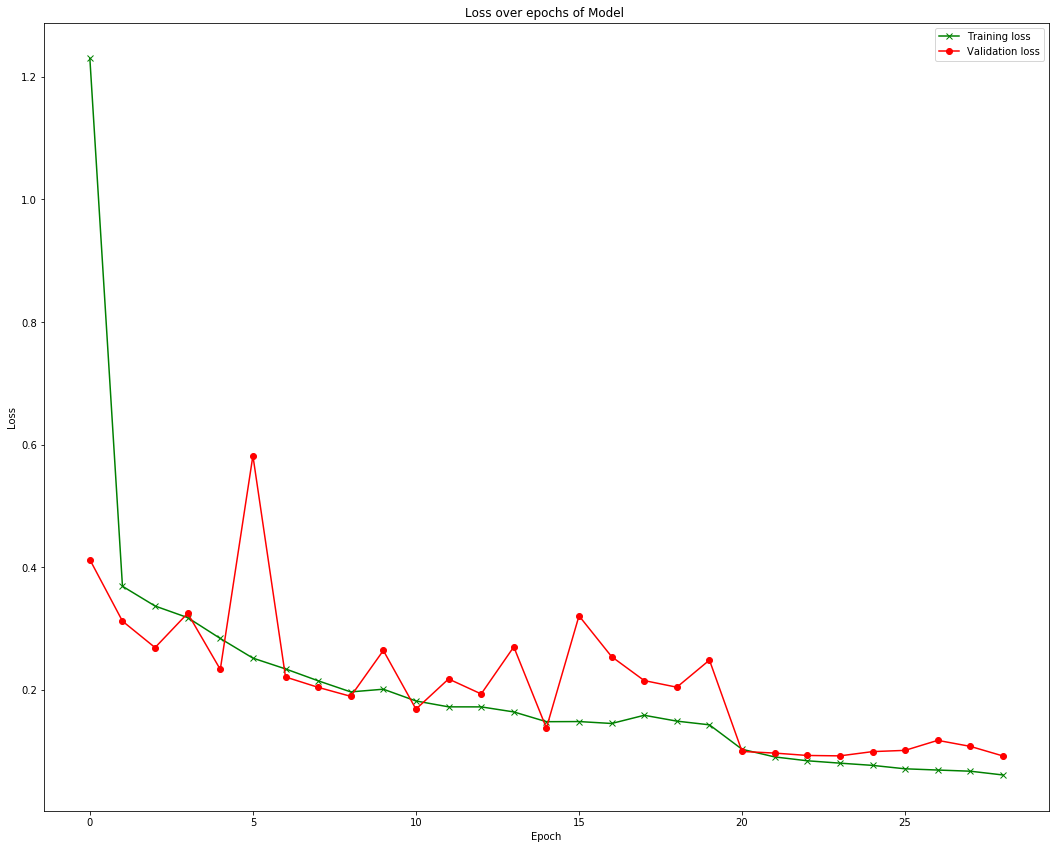

In [28]:
#ve do thi loss (train, val)
def visualize_loss (checkpoint, path_loss):
    loss = checkpoint['loss_list'] 
    train_loss = [x['train_loss'] for x in loss]
    valid_loss = [x['valid_loss'] for x in loss]
    fig, ax = plt.subplots(figsize = (18, 14.5))
    ax.plot(train_loss, '-gx', label='Training loss')
    ax.plot(valid_loss , '-ro', label='Validation loss')
    ax.set(title="Loss over epochs of Model ",
    xlabel='Epoch',
    ylabel='Loss')
    ax.legend()
    fig.show()
    plt.savefig(path_loss)
visualize_loss(checkpoint, './loss2.png')

/home/trucloan/anaconda3/envs/me/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  del sys.path[0]


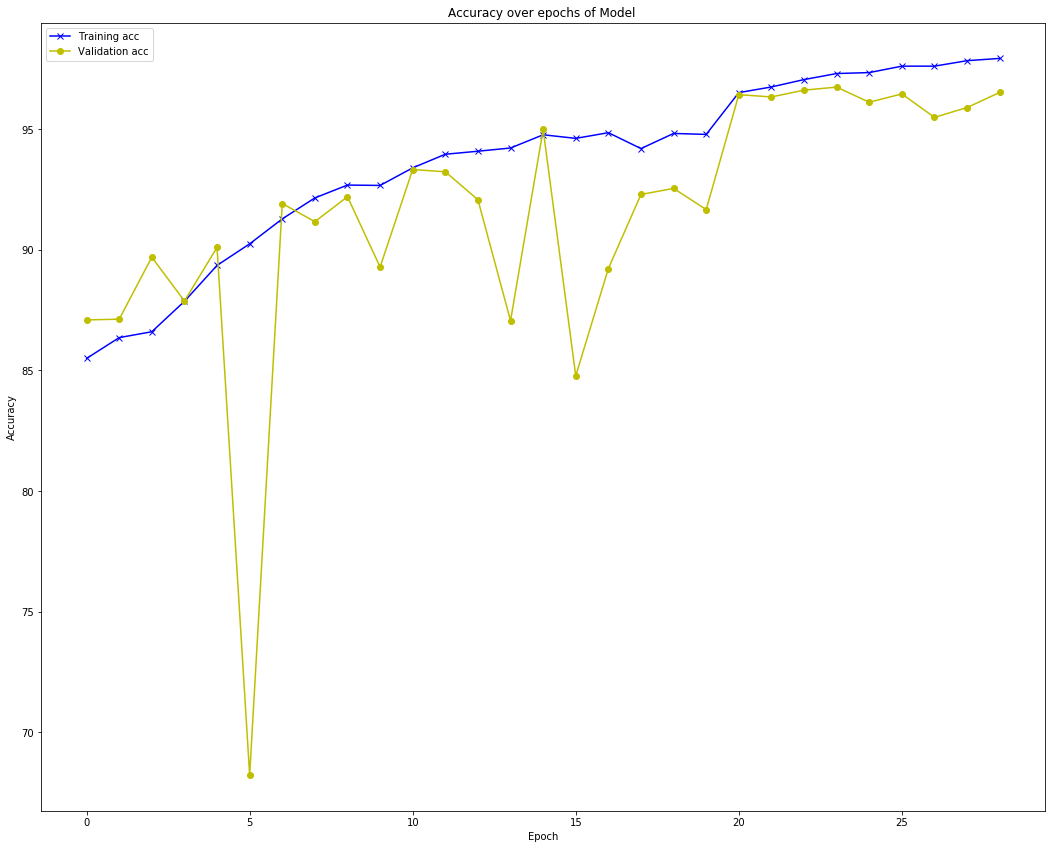

In [29]:
#ve do thi acc (train, val)
def visualize_acc (checkpoint, path_acc):
    acclist = checkpoint['train_acc'] #
    train_acc = [x['train_acc'] for x in acclist]
    valid_acc = [x['valid_acc'] for x in acclist]
    fig, ax = plt.subplots(figsize = (18, 14.5))
    ax.plot(train_acc, '-bx', label='Training acc')
    ax.plot(valid_acc , '-yo', label='Validation acc')
    ax.set(title="Accuracy over epochs of Model ",
    xlabel='Epoch',
    ylabel='Accuracy')
    ax.legend()
    fig.show()
    plt.savefig(path_acc)
visualize_acc(checkpoint, './Accuracy.png')

In [32]:
#test model
def test_loop():
    with torch.no_grad():
        y_true = []
        y_pred = []
        model.to(device)
        model.eval()
        for sample in test_dataloader:
            batch_size = sample['image'].size(0)
            data = sample['image'].to(device)
            target = sample['labels'].to(device)
            output = model(data)
            _,pred = torch.max(output, 1)
            y_true += target.tolist()
            y_pred += pred.tolist()
    return y_true, y_pred


y_true, y_pred = test_loop()
        

In [33]:
accuracy = accuracy_score(y_true, y_pred)
accuracy

0.9425

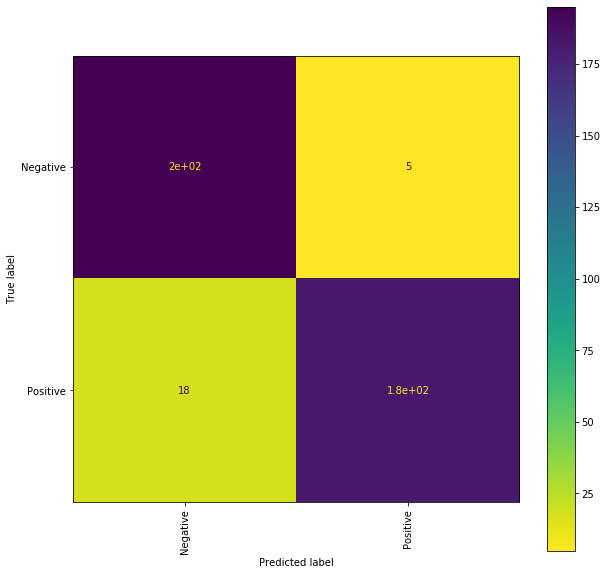

In [34]:
cnf_matrix = confusion_matrix(y_true, y_pred)
fix, ax = plt.subplots(figsize = (10,10))
disp = ConfusionMatrixDisplay(confusion_matrix = cnf_matrix, display_labels = classes)
disp.plot(include_values = True, cmap = 'viridis_r', ax = ax, xticks_rotation = 'vertical')
plt.savefig('Matrix.png')

In [35]:
path_rp = './reportVGG19bn.txt'
try:
    s = classification_report(y_true, y_pred, target_names = classes)
    with open(path_rp, mode ='x') as f:
        f.write(s)
    with open(path_rp) as f:
        print(f.read())
    f.close()
except FileExistsError:
    pass

In [38]:
# Predict images
def img_transform(path_img):
    img = Image.open(path_img)
    imagetensor = test_transform(img).cuda()
    return imagetensor

def predict(path_img, verbose = False):
    if not verbose:
        warnings.filterwarnings('ignore')
    try:
        checks_if_model_is_loaded = type(model)
    except:
        pass
    model.eval()
    if verbose:
        print('Model loader ...')
    image = img_transform(path_img)
    image1 = image[None,:,:,:]
    
    with torch.no_grad():
        outputs = model(image1)
        
        _,pred_int = torch.max(outputs.data, 1)
        _,top1_idx = torch.topk(outputs.data, 1, dim = 1)
        pred_idx = int(pred_int.cpu().numpy())
        if pred_idx == 0:
            pred_str = str('Negative')
            print('img: {} is: {}'.format(os.path.basename(path_img), pred_str))
        else:
            pred_str = str('Positive')
            print('img: {} is: {}'.format(os.path.basename(path_img), pred_str))
            
    

img: covid.jpg is: Positive


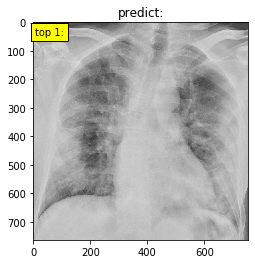

In [39]:
pred_str = str('')
path_image = './pred/covid.jpg'

img = Image.open(path_image)
plt.imshow(img)

predict(path_image)
plt.title('predict:{}'.format(pred_str))
plt.text(5,45,'top {}:{}'.format(1,pred_str), bbox = dict(fc='yellow'))
plt.show()